# Notebook 3: Regional Information Transfer

## Characterization of Long-Term Runoff

In [1]:
import math
import pandas as pd
import numpy as np
from scipy import stats as st

import matplotlib.pyplot as plt

## Introduction

In Notebook 2, we developed a rating curve for our location of interest based on discrete discharge measurements made during a series of visits, and we applied this stage-discharge relationship (rating curve) to the continous stage recorded at our hydrometric station to generate a discharge (flow) time series.  

Recall that our hydrometric station has only been running for a couple of years -- this isn't nearly enough data to estimate the **long term** flow characteristics (daily, seasonal, floods, droughts, etc.).  In this notebook, we look in the vicinity of our project location for other stations where records have been kept for much longer&mdash;ideally with complete historical records of 25+ years.  **It's also critical that we find records that are concurrent with the period we measured at our project location.**  We can use concurrent data from nearby stations to develop a model to estimate flow for periods we didn't actually measure at our project location.  This type of model is called a *regional information transfer* model.

First, we'll set up our rating curve as we did in Notebook 2 and recalculate the daily average flow series.

>**Note**: throughout these notebooks, the short form cms (cubic metres per second) is used interchangeably, and denoted as `m3/s`, `m^3/s` and  $m^3/s$.

## Import the Data

In [2]:
# import the stage data (from the Notebook 2 data folder)
site_df = pd.read_csv('../../notebook_data/notebook_2_data/WL_data.csv', parse_dates=['Date'])
site_df.set_index('Date', inplace=True)

In [3]:
# take a quick look at what we're dealing with
site_df.head()

,Water level (daily av.) (m)
Date,
2009-01-01,0.240
2009-01-02,0.236
2009-01-03,0.234
2009-01-04,0.233
2009-01-05,0.231


In [4]:
# let's store the stage label as a variable for convenience
stage_label = 'Water level (daily av.) (m)'

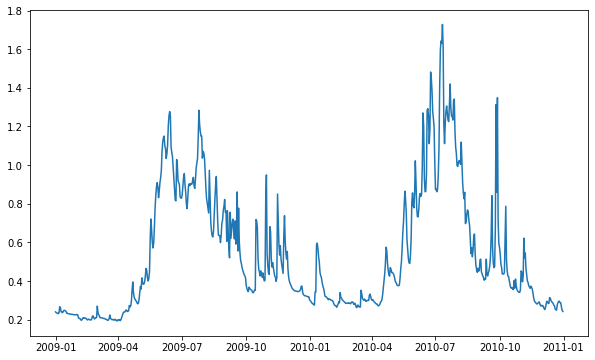

In [5]:
# plot the data for a quick visual check
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(site_df.index, site_df[stage_label])

In [6]:
# import the discharge measurements
rc_df = pd.read_csv('../../notebook_data/notebook_2_data/RC_Data.csv', parse_dates=['Date'])

In [7]:
# take a look at the discharge measurements
rc_df.head(15)

,Date,Flow (m3/s),Water level (m)
0,2009-01-02,1.565,0.236
1,2009-01-07,1.530,0.267
2,2009-03-20,0.967,0.224
3,2009-09-12,5.133,0.707
4,2009-11-10,3.402,0.468
5,2009-11-18,4.474,0.589
6,2010-03-24,1.297,0.296
7,2010-03-25,1.823,0.300
8,2010-08-25,4.682,0.632


In [8]:
# remember to add in the newest discharge measurement(s)!
msmt_date = pd.to_datetime('2010-09-26')
msmt_q = 12
# note that in stage_df, the index has been set to the Date column
msmt_stage = site_df[site_df.index == msmt_date].values[0]

rc_df.loc[len(rc_df), :] = [msmt_date, msmt_q, msmt_stage]
rc_df

/home/danbot/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,Date,Flow (m3/s),Water level (m)
0,2009-01-02,1.565,0.236
1,2009-01-07,1.530,0.267
2,2009-03-20,0.967,0.224
3,2009-09-12,5.133,0.707
4,2009-11-10,3.402,0.468
5,2009-11-18,4.474,0.589
6,2010-03-24,1.297,0.296
7,2010-03-25,1.823,0.300
8,2010-08-25,4.682,0.632
9,2010-09-26,12.000,1.313


## Plot the Stage-Discharge Rating Curve and the Best Fit Curve

Recall the form of the rating curve equation from Notebook 2: $Q = C(H-h_0)^b$.  If we transform the data to log space, we get a linear relationship:

$$log(Q) = log(C) + b\cdot log(h-h_0)$$

If we rearrange to the form $y = intercept + slope \cdot x$, we can use the scipy function for linear regression (`scipy.stats.linregress()` shortened at import to `st.linregress()` from the previous tutorial).

Recall the x and y axis parameters are Q and h, respectively, so the linear form of the equation is then: 

$$log(h-h_0) = slope \cdot log(Q) + intercept$$

The above relationship is linear, so we can use ordinary least squares to find the best fit line (in log-log space), and then transform back to linear space.
Note that $h_0$ cannot be fitted this way, and has to be set manually. In this case we will use $h_0=0$ as a first approximation and check the fit to see if an adjustment is warranted.

In [17]:
# calculate the discharge based on the best fit
# parameters found by ordinary least squares above
def ols_rc_q(slope, intercept, h, h0):
    """
    Calculate flow (Q) from the linear best fit parameters.
        -slope: the `log_slope` calculated above (constant)
        -intercept: `log_intercept` calculated above (constant)
        -h0 is the same PZF offset used above (constant)
        -h is the independent variable
    Returns Q, the discharge in m^3/s.
    """
    if slope == 0:
        return 0
    try:
        return np.exp((np.log(h - h0) - intercept) / slope)
    except ValueError: 
        return None

In [18]:
# Find the best-fit line in log-log space
# take the logarithm of the measured streamflows and stage
h0=0
q_log = np.log(rc_df['Flow (m3/s)'] - h0)
stage_log = np.log(rc_df['Water level (m)'])

# find the parameters describing the linear best fit using ordinary least squares (OLS)
log_slope, log_intercept, log_rval, log_pval, log_stderr = st.linregress(q_log, stage_log)

In [19]:
stage_range = np.linspace(0.001, 1.5, 100)
# put best fit results into a dataframe for plotting
# use 0 as the PZF (point of zero flow) (the h0 parameter)
bf_df = pd.DataFrame()
bf_df['stage'] = stage_range

# now as before, apply the `ols_rc_q` function to create the stage-discharge
# curve based on the best-fit equation
bf_df['best_fit_q'] = [ols_rc_q(log_slope, log_intercept, h, 0.0) for h in stage_range]
bf_df.sort_values(by='stage', inplace=True)

## Calculate Daily Average Discharge

From the equation describing the ordinary least squares (OLS) best fit of the measured discharge,
calculate daily average flow from daily average water level.

In [20]:
site_df.head()

,Water level (daily av.) (m),RC Q (cms)
Date,,
2009-01-01,0.240,1.235033
2009-01-02,0.236,1.206657
2009-01-03,0.234,1.192538
2009-01-04,0.233,1.185495
2009-01-05,0.231,1.171445


In [21]:
# here we apply the rating curve equation function to the entire 
# water level time series
site_df['RC Q (cms)'] = site_df[stage_label].apply(lambda h: ols_rc_q(log_slope, log_intercept, h, 0))

In [22]:
site_df.head()

,Water level (daily av.) (m),RC Q (cms)
Date,,
2009-01-01,0.240,1.235033
2009-01-02,0.236,1.206657
2009-01-03,0.234,1.192538
2009-01-04,0.233,1.185495
2009-01-05,0.231,1.171445


In [23]:
rc_df.columns

Index(['Date', 'Flow (m3/s)', 'Water level (m)'], dtype='object')

### Plot the Rating Curve and Resultant Flow Series

The two plots below are linked.  Check the selection tools, and select points on one plot.  When validating data, it is helpful to be able to link the measurements on the rating curve plot and the daily flow series plot.  Consider how you would you check if the low flows were subject to a shift in the hydraulic control over time?    

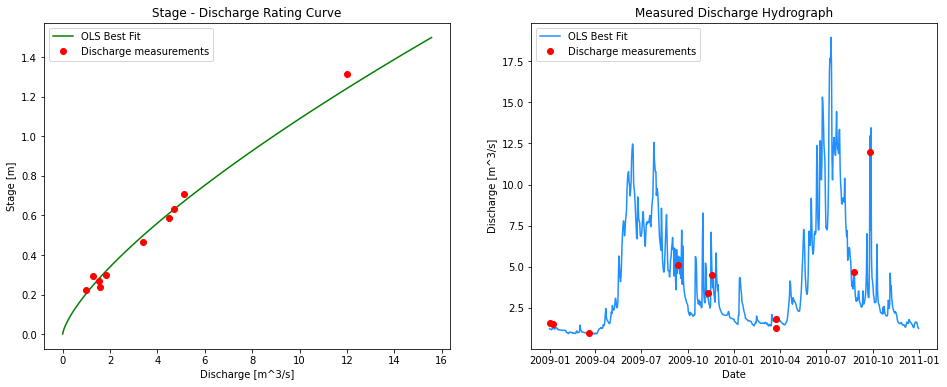

In [24]:
# here we specify 1, 2 for subplots meaning 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(16,6))

# left side plot - rating curve
ax[0].plot(bf_df['best_fit_q'], bf_df['stage'],
        color='green', label="OLS Best Fit")

ax[0].plot(rc_df['Flow (m3/s)'], rc_df['Water level (m)'], 
           marker='o', color='r',
           linestyle='',
           label='Discharge measurements')

# right side plot -- hydrograph
ax[1].plot(site_df.index, site_df['RC Q (cms)'],
        color='dodgerblue', label="OLS Best Fit")

ax[1].plot(rc_df['Date'], rc_df['Flow (m3/s)'], 
           marker='o', color='r',
           linestyle='',
           label='Discharge measurements')

ax[0].set_title('Stage - Discharge Rating Curve')
ax[0].set_xlabel('Discharge [m^3/s]')
ax[0].set_ylabel('Stage [m]')
ax[0].legend()
# right side plot labels
ax[1].set_title('Measured Discharge Hydrograph')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Discharge [m^3/s]')
ax[1].legend()
plt.show()

### Cumulative Frequency: The Flow Duration Curve (FDC)

In order to illustrate the variability of flow in a river, it is common to map flow magnitude to cumulative frequency, or the proportion of time the flow in the river equals or exceeds some amount.  A flow duration curve presents flow magnitude from 0% to 100% exceedance, where values approaching zero are high flows that are very rarely exceeded.  Conversely, values approaching 100% exceedance are low flows that are almost always exceeded.  **50% exceedance represents the median flow**  Note that these values are based on the sample, and the flow duration curve is generally used to describe the overall distribution of flow and not for estimating extremes.  A *flow duration* curve is also referred to as a *flow exceedance* curve. 

Let's plot a flow duration curve for the measured flow series we created above by applying the rating curve equation to the stage series.

Text(0.5, 0, 'Percent of Time Exceeded [%]')

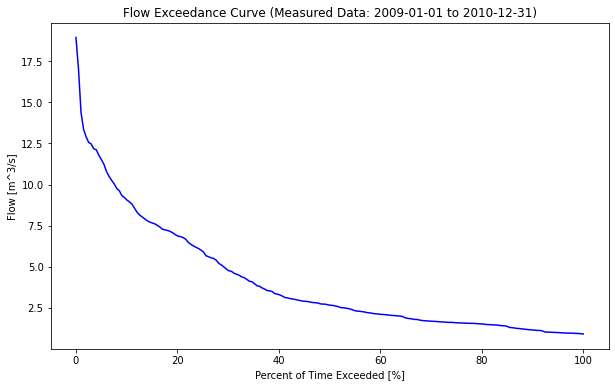

In [25]:
fig, ax = plt.subplots(figsize=(10,6))

pct_exceeded = np.linspace(0, 100, 200)
flow_quantiles = np.percentile(site_df['RC Q (cms)'].dropna(), pct_exceeded)

start_date, end_date = site_df.index[0], site_df.index[-1]

ax.plot(pct_exceeded[::-1], flow_quantiles, 'b-')
ax.set_title(f'Flow Exceedance Curve (Measured Data: {start_date:%Y-%m-%d} to {end_date:%Y-%m-%d})')
ax.set_ylabel('Flow [m^3/s]')
ax.set_xlabel('Percent of Time Exceeded [%]')

The shape of the FDC gives some insight into the fluctuation of flows in the watershed.  A steeper peak flow end suggests more dramatic 'flashes' of rainfall-runoff response.  The shape of the low-flow tail describes base flows during low flow seasons.  Below is a comparison of two basins of nearly identical size but in very different climates:

![Comparison of flow exceedance curves for two basins in BC and Alberta.](img/FDC_comparison.png)

From the plot above, the Alberta basin looks to be a bit bit drier, but a dramatic difference in low-flows can be seen by looking closer at the low-flow range:

![Comparison of flow exceedance curves for two basins in BC and Alberta, with a focus on low-flow range.](img/FDC_comparison_low_flow.png)


An FDC is also informative to compare **different estimates at the same location**, such as a measured vs. modeled flow series.

Next we'll develop a regional regression model and then use the FDC to evaluate the quality of our model *over specific flow quantiles* -- this is important for the different end-uses of the data.

## Linear Regression of Daily Streamflow

![Active WSC Stations in Western Canada](img/wsc_map_view1.png)

Water Survey of Canada (WSC) has operated and maintained hydrometric stations across Canada for over 100 years.  If we can find a regional proxy WSC station in **close proximity to our location of interest, with similar basin characteristics** to those of our project, we can correlate daily streamflow between the two locations, ultimately to generate an estimated (also called synthetic or modeled) long-term flow series for our project location.

Typically regressions are done by chronological pairing, which effectively says "if the flow at the regional (proxy) station was $Q_p$ at time $t$, the flow at our project location at time $t$ will be approximately linearly proportional.

### Chronological Pairing (CP)

A lot of work goes into finding an appropriate long-term record comparable to our location of interest, but we will assume we have been given a long-term daily flow series to use.

1.  Find just the concurrent days of record (days where we have flow recorded at **both creeks/rivers**).
2.  Create a scatter plot where the x, y coordinates of each data point are (flow1, flow2).  It is customary to put the long-term regional station on the x-axis.
3.  Determine the equation describing the line of best fit through the data.
4.  Apply the best fit line equation to the long-term surrogate record to yield an estimated long-term series for the project location.

To further refine this estimate, we can recognize that the mechanisms driving flow across seasons and months can change quite dramatically, and the relationship between the two catchments can also change month-by-month, and/or season by season.  If there is enough data to create seasonal or monthly regressions, we can develop a best-fit equation for each month or season.  The process of steps 2 through 4 then are the same, except we treat each season or month independently.  

The above method is referred to as **chronological pairing (CP)**, as it pairs flows occurring at the same time.  But what if there are timing differences between stations, or what if the spatial variability of precipitation results in flow events that don't coincide in the short term?  

### Empirical Frequency Pairing

To eliminate the temporal constraint on timing of events at the daily level, instead of comparing concurrent days, we can compare magnitudes of flows. This method is referred to as Empirical Frequency Pairing (EFP) and is commonly used in British Columbia.  Empirical frequency pairing still uses concurrent records, however it is the ranked flows in each series that are compared, i.e. the data points on an EFP plot are:  

$$[(R1_{siteA}, R1_{site_B}), (R2_{siteA}, R2_{siteB}), ..., (Rn_{siteA}, Rn_{siteB})]$$  

The steps to derive an estimated long-term flow series for our location of interest are the same (i.e. steps 2-4 above).

### Set up a Chronological Pairing Regression

The first step is to import the regional data series and find all of the dates with values for both locations.

Previewing the data shows line 1 has information about two distinct parameters.  Where the `PARAM` column value is 1, the `Value` column corresponds to daily discharge ($\frac{m^3}{s}$ and where the `PARAM` column value is 2, the `Value` column corresonds to daily water level ($m$).  

>**Note**: At the point of data import, we also need to correctly set the header line to index 1 (the second row), because the file has a row of information describing the PARAM values above the actual column header row.  See for yourself by opening up the csv file.

In [26]:
# set the header row to index 1, tell the function to set the 
# `Date` column as the index.
regional_df = pd.read_csv('../../notebook_data/notebook_3_data/Regional_data.csv', header=1, parse_dates=True, index_col='Date')

# filter for only the discharge data (PARAM == 1)
regional_df = regional_df[regional_df['PARAM'] == 1]
 
# preview the data
regional_df.head()

,PARAM,Value,SYM
Date,,,
1987-01-26,1,0.283,A
1987-01-27,1,0.240,B
1987-01-28,1,0.240,B
1987-01-29,1,0.273,NaN
1987-01-30,1,0.255,NaN


In [27]:
# check the date range covered by the regional data
print('Period of Record:')
print(f'    Regional data: {regional_df.index[0]:%Y-%m-%d} to {regional_df.index[-1]:%Y-%m-%d}')

# check the date range covered by our data measured at site
print(f'        Site data: {site_df.index[0]:%Y-%m-%d} to {site_df.index[-1]:%Y-%m-%d}')

Period of Record:
    Regional data: 1987-01-26 to 2017-12-31
        Site data: 2009-01-01 to 2010-12-31


### Obtain Concurrent Data

From the previous step, we can see that the regional dataset encompasses the date range of our site data.  To perform a linear regression, we want to use **concurrent data only**.   The `concat`, or concatenate, function [documentation can be found here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html). 

>**Note**: the `concat` function is used to combine dataframes.  We want to combine two dataframes based on concurrent days.  The `concat` function requires the dataframes to have `datetime`/`timestamp` type indices.

In [28]:
print(type(site_df.index[0]))
print(type(regional_df.index[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Above we can see that both dataframe indices are `timestamp` types.

In [29]:
# create a new dataframe of concurrent data and plot the data
# join='inner' says to line up the indices and get the 
# values that are common between the two dataframes
# axis=1 says line up columns instead of rows
concurrent_df = pd.concat([site_df, regional_df], join='inner', axis=1)
concurrent_df.head()

,Water level (daily av.) (m),RC Q (cms),PARAM,Value,SYM
Date,,,,,
2009-01-01,0.240,1.235033,1,0.240,B
2009-01-02,0.236,1.206657,1,0.230,B
2009-01-03,0.234,1.192538,1,0.225,B
2009-01-04,0.233,1.185495,1,0.208,B
2009-01-05,0.231,1.171445,1,0.200,B


## Regression Plot

Plot the concurrent daily flows between the project location and the regional station to see if there is a correlation between the two that could be used to develop a model for our project location.

Text(0.5, 0, 'Regional Q [m^3/s]')

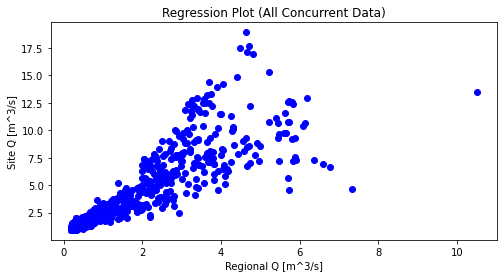

In [30]:
#### Regression Plot
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(concurrent_df['Value'], concurrent_df['RC Q (cms)'], 'bo')
ax.set_title('Regression Plot (All Concurrent Data)')
ax.set_ylabel('Site Q [m^3/s]')
ax.set_xlabel('Regional Q [m^3/s]')

In [31]:
# find the best fit equation
slope, intercept, rval, pval, stderr = st.linregress(concurrent_df['Value'], concurrent_df['RC Q (cms)'])

In [32]:
sign = '+'
if intercept < 0:
    sign = '-'

print('Regression Equation:')
print(f'    Q_site = {slope:.1f}xQ_regional {sign} {intercept:.1f}')

Regression Equation:
    Q_site = 1.9xQ_regional + 0.9


Add the best fit line (regression model) to the plot.

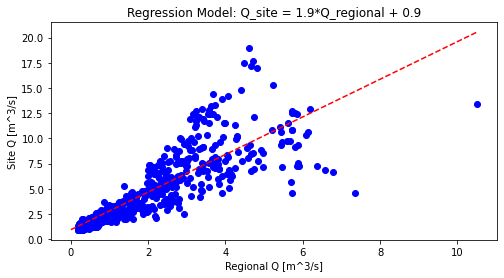

In [33]:
x_range = 0, concurrent_df['Value'].max()
model_q = [slope * x + intercept for x in x_range]

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(concurrent_df['Value'], concurrent_df['RC Q (cms)'], 'bo')
ax.set_title(f'Regression Model: Q_site = {slope:.1f}*Q_regional {sign} {intercept:.1f}')
ax.set_ylabel('Site Q [m^3/s]')
ax.set_xlabel('Regional Q [m^3/s]')
ax.plot(x_range, model_q, 'r--')


## Create long-term daily flow series for the project location

The last step in the process of a long-term flow estimate for our project location is to use the equation of the best fit line (the model) to calculate estimated daily flows over periods where flow was not measured at our project location.

In [64]:
regional_df.columns

Index(['PARAM', 'Value', 'SYM'], dtype='object')

In [65]:
# map the equation of the best fit line to the regional flow series
# to get the long-term modeled flow series for the project location
regional_df['Model_q_cms'] = regional_df['Value'].apply(lambda q: slope * q + intercept)

In [66]:
regional_df.columns

Index(['PARAM', 'Value', 'SYM', 'Model_q_cms'], dtype='object')

## Compare the model flow series to the measured series

In [67]:
# compare the modeled vs. measured flow series 
# 
concurrent_df['Model_q_cms'] = concurrent_df['Value'].apply(lambda q: slope * q + intercept)
concurrent_df.head()

,Water level (daily av.) (m),RC Q (cms),PARAM,Value,SYM,Model_Q,residuals,Model_q_cms
Date,,,,,,,,
2009-01-01,0.240,1.235033,1,0.240,B,1.384534,0.149501,1.384534
2009-01-02,0.236,1.206657,1,0.230,B,1.365869,0.159212,1.365869
2009-01-03,0.234,1.192538,1,0.225,B,1.356537,0.163999,1.356537
2009-01-04,0.233,1.185495,1,0.208,B,1.324807,0.139312,1.324807
2009-01-05,0.231,1.171445,1,0.200,B,1.309875,0.138430,1.309875


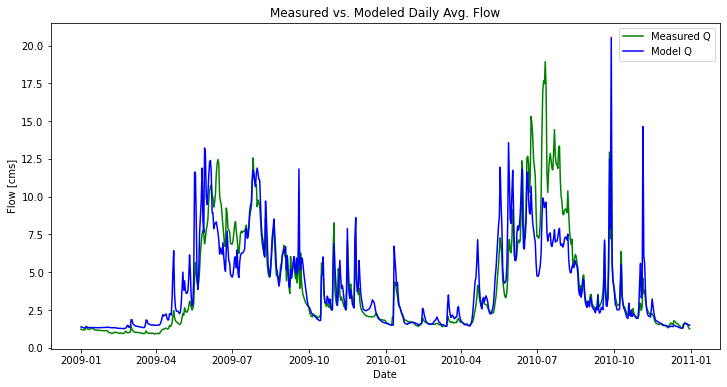

In [68]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(concurrent_df.index, concurrent_df['RC Q (cms)'], 'g-', label='Measured Q')
ax.plot(concurrent_df.index, concurrent_df['Model_q_cms'], 'b-', label='Model Q')

ax.set_title('Measured vs. Modeled Daily Avg. Flow')
ax.set_xlabel('Date')
ax.set_ylabel('Flow [cms]')
ax.legend()

### In the above plot, note general patterns, specific exceptions, and any trends

Note the big deviation between the two series in the summer of 2010.  This looks like our model is doing a particularly bad job in the late summer.  How about in other seasons?   How is the model doing at predicting peaks?  

>**Note**: in the figure above, we label one series as "Measured Q" but in reality recall it is not *directly* measured.  It is itself a model of the relationship between stage and discharge.  **The rating curve equation is the model!**

### Best-fit

The least-squares best fit is a common way to define the linear relationship between two variables.  It is a minimization of the sum of squared differences between the line (the model) and the observation.  Because it uses the square difference, it is sensitive to outliers.  It is good practice to check the residuals of the model to see if our model contains bias, and make an adjustment if warranted.  We can exclude outliers from the best fit (but still show them in the plot!), or we could use the L1-norm, which is the sum of absolute differences which is more robust to outliers.

Below, we'll apply the best fit model to the regional data for the period of measured record, we'll calculate the difference (residuals) between modeled and measured flows, and then we'll plot these residuals to look for bias in our model.

In [ ]:
# create a series to represent the modeled flow 
concurrent_df['Model_Q'] = concurrent_df['Value'] * slope + intercept

# find the residuals
concurrent_df['residuals'] =  concurrent_df['Model_Q'] - concurrent_df['RC Q (cms)']

Text(0.5, 1.0, 'Histogram of Residuals')

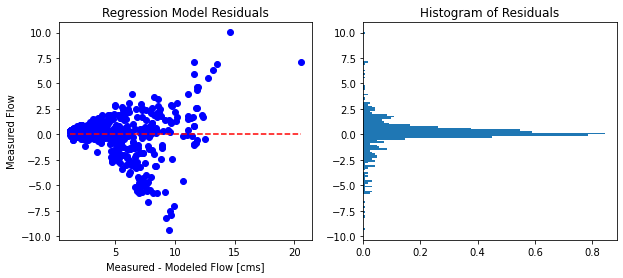

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

sorted_df = concurrent_df.sort_values('Model_Q').copy()

ax[0].plot(sorted_df['Model_Q'], sorted_df['residuals'], 'bo')
ax[0].plot([sorted_df['Model_Q'].min(), sorted_df['Model_Q'].max()], [0, 0], 'r--')
ax[0].set_title(f'Regression Model Residuals')
ax[0].set_xlabel('Measured - Modeled Flow [cms]')
ax[0].set_ylabel('Measured Flow')

# plot a histogram of the residuals to assess the distribution of error
a = plt.hist(sorted_df['residuals'], bins='auto', 
orientation='horizontal', density=True)
ax[1].set_title('Histogram of Residuals')

# toggle the line below to see a closeup around 0
# ax[1].set_ylim(-1.5, 1.5)

### Compare measured vs. modeled flow duration curves

How else can we evaluate how the model is fitting the measured data, noting in particular that we are interested in certain ranges of flows, perhaps for generating energy year-round, or supplying a community with drinking water in a dry season?

Recall how we plotted the flow duration curve in Notebook 3.  The flow duration curve is particularly useful for focusing on how well the model matches measured data across the range of flows (though extremes are de-emphasized). 

What do the differences between flow duration curves shown below suggest about how well our model represents the project area?  

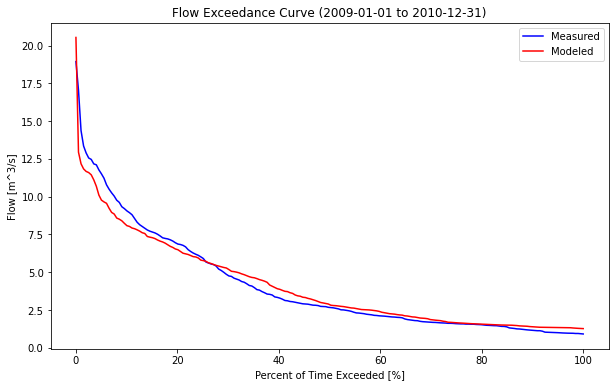

In [71]:
fig, ax = plt.subplots(figsize=(10,6))

pct_exceeded = np.linspace(0, 100, 200)
msd_flow_quantiles = np.percentile(concurrent_df['RC Q (cms)'].dropna(), pct_exceeded)
model_flow_quantiles = np.percentile(concurrent_df['Model_q_cms'].dropna(), pct_exceeded)

start_date, end_date = concurrent_df.index[0], concurrent_df.index[-1]

#plot the measured series FDC
ax.plot(pct_exceeded[::-1], msd_flow_quantiles, 'b-', label='Measured')
#plot the measured series FDC
ax.plot(pct_exceeded[::-1], model_flow_quantiles, 'r-', label='Modeled')

ax.set_title(f'Flow Exceedance Curve ({start_date:%Y-%m-%d} to {end_date:%Y-%m-%d})')
ax.set_ylabel('Flow [m^3/s]')
ax.set_xlabel('Percent of Time Exceeded [%]')
ax.legend()

## Estimate the Long-Term Mean Annual Flow for our Project Location

Compare the long term mean annual against the short term, then compare the long-term monthly and annual series.

In [72]:
regional_df.head()

,PARAM,Value,SYM,Model_q_cms
Date,,,,
1987-01-26,1,0.283,A,1.464792
1987-01-27,1,0.240,B,1.384534
1987-01-28,1,0.240,B,1.384534
1987-01-29,1,0.273,NaN,1.446127
1987-01-30,1,0.255,NaN,1.412531


In [73]:
# first drop any NaN values so we can calculate mean and percentile values
regional_df.dropna(subset=['Model_q_cms'], inplace=True)

lt_mad = regional_df[['Model_q_cms']].mean().values[0]
msd_mean = site_df[['RC Q (cms)']].mean().values[0]

lt_median = np.percentile(regional_df['Model_q_cms'], 50)
msd_median = site_df[['RC Q (cms)']].median().to_numpy()[0]

print(f'The estimated long-term mean annual flow (MAD) at our project location is {lt_mad:.1f} m^3/s')
print(f'The average flow over the measured period was {msd_mean:.1f} m^3/s')
print(f'The estimated long-term median flow is {lt_median:.1f} m^3/s')
print(f'The median flow over the measured period was {msd_median:.1f} m^3/s')

The estimated long-term mean annual flow (MAD) at our project location is 4.1 m^3/s
The average flow over the measured period was 4.1 m^3/s
The estimated long-term median flow is 3.2 m^3/s
The median flow over the measured period was 2.7 m^3/s


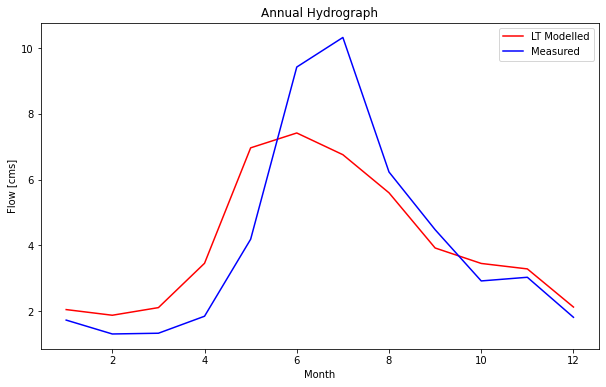

In [74]:
regional_df['month'] = regional_df.index.month
annual_series = regional_df[['Model_q_cms', 'month']].groupby('month').mean()

site_df['month'] = site_df.index.month
msd_ann = site_df[['month', 'RC Q (cms)']].groupby('month').mean()

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(annual_series['Model_q_cms'], 'r-', label='LT Modelled')
ax.plot(msd_ann['RC Q (cms)'], 'b-', label='Measured')
ax.set_title('Annual Hydrograph')
ax.set_xlabel('Month')
ax.set_ylabel('Flow [cms]')
ax.legend()

The two series above highlight the difference a long-term estimate can make.  If we were to base a model on the short term measured series (blue), we might underestimate the flow available in the winter months (when energy is especially valuable), or overestimate the snowmelt in spring **over the long term**.

## Questions for Reflection

1.  From our regression plot and from the comparison of measured and estimated daily flow series, what do you think about the quality of our model, i.e. how well does the best fit line approximate the concurrent daily flows (blue dots)?  
2.  What flow is exceeded 50% OR MORE of the time, how well is this range modelled and what might this flow range be pertinent to for a hydropower project?  
3.  What could differences in concurrent flows at the two locations be attributable to?  
4.  How might we modify our model to capture one of the differences you noted in 3?
5.  In the last plot, we see that the ~two years we measured had a dramatically higher spring runoff compared to the long-term, and lower winter base flows.  What we took these years as representative without modeling the long-term flow distribution?

## References

1. A.S. Hamilton & R.D. Moore (2012). Quantifying Uncertainty in Streamflow Records , Canadian Water Resources Journal / Revue canadienne des ressources hydriques, 37:1, 3-21, DOI: 10.4296/cwrj3701865
2. Environment Canada (2012).  Hydrometric Manual - Data Computations.  Water Survey of Canada, Weather and Environmental Monitoring Directorate.